In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,

)
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import time
import psutil
import threading
from memory_profiler import memory_usage

import joblib


/home/wahba/miniconda3/envs/ml1/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
# Load the dataset
df = pd.read_csv('/home/wahba/Documents/dataset/processed/3_cicids2017_attack_only.csv')

# Remove rows where 'Label' is 'Bot'
df.drop(df[df['Label'] == 'Bot'].index, inplace=True)
df['Label'].value_counts()

Label
DoS           321764
PortScan       90819
BruteForce      9152
WebAttack       2143
Name: count, dtype: int64

In [3]:
selected_features = [
    # Flow-level
    'Flow Duration',
    'Flow Packets/s',
    'Flow Bytes/s',
    'Flow IAT Mean',
    'Flow IAT Max',
    'Flow IAT Std',
    
    # Forward features
    'Fwd Header Length',
    'Fwd IAT Total',
    'Fwd IAT Mean',
    'Fwd IAT Max',
    'Fwd IAT Std',
    'Fwd Packet Length Min',
    'Fwd Packet Length Max',
    'Fwd Packet Length Mean',
    'Fwd Packet Length Std',
    'Subflow Fwd Bytes',
    'Total Fwd Packets',
    'Total Length of Fwd Packets',
    
    # Backward features
    'Bwd Header Length',
    'Bwd Packet Length Min',
    'Bwd Packet Length Max',
    'Bwd Packet Length Std',
    'Bwd Packets/s',
    'Init_Win_bytes_backward',
    
    # Packet-level
    'Packet Length Mean',
    'Packet Length Std',
    'Packet Length Variance',
    'Average Packet Size',
    'PSH Flag Count',
    'Init_Win_bytes_forward',
    'Max Packet Length',

    'Label',
]

# Keep only the selected features
df = df[selected_features]

# 1.0 Dataset Preparation

## 1.1 Training and Testing Dataset Splitting

In [4]:
# splitting df for training and testing using stratified split
X = df.drop('Label', axis=1) # features
y = df['Label'] # target

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

X_train = strat_train_set.drop("Label", axis=1)
y_train = strat_train_set["Label"]

X_test = strat_test_set.drop("Label", axis=1)
y_test = strat_test_set["Label"]

label_mapping = {'DoS': 0, 'PortScan': 1, 'BruteForce': 2, 'WebAttack': 3}
y_train = y_train.map(label_mapping)
y_test  = y_test.map(label_mapping)

print(pd.DataFrame({
    "count (df)": df["Label"].value_counts(),
    "count (train_set)": strat_train_set["Label"].value_counts(),
    "count (test_set)": strat_test_set["Label"].value_counts(),
    "proportion": strat_train_set["Label"].value_counts(normalize=True),
})
)

            count (df)  count (train_set)  count (test_set)  proportion
Label                                                                  
DoS             321764             257411             64353    0.759096
PortScan         90819              72655             18164    0.214257
BruteForce        9152               7322              1830    0.021592
WebAttack         2143               1714               429    0.005055


## 1.2 Feature Scaling for KNN using Robust Scaler

In [5]:
rbscaler = RobustScaler()

# fit and transform training data, transform testing data
X_train_scaled = rbscaler.fit_transform(X_train)
X_test_scaled = rbscaler.transform(X_test)

print(pd.DataFrame({
    "count": y_train.value_counts(),
    "proportion": y_train.value_counts(normalize=True)
})
)

joblib.dump(rbscaler, '/home/wahba/Documents/model/multi_class_classification2/robust_scaler.joblib')

        count  proportion
Label                    
0      257411    0.759096
1       72655    0.214257
2        7322    0.021592
3        1714    0.005055


['/home/wahba/Documents/model/multi_class_classification2/robust_scaler.joblib']

## 1.3 Dataset Resampling

In [6]:
over = SMOTE(sampling_strategy={
    2: 15000,
    3: 8000,
})

under = RandomUnderSampler(sampling_strategy={
    0: 90000,
    1: 30000,
})

pipeline = Pipeline([
    ('over', over),
    ('under', under)
])

X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)
X_train_scaled_resampled, y_train_scaled_resampled = pipeline.fit_resample(X_train_scaled, y_train)

print(pd.DataFrame({
    "count": y_train_resampled.value_counts(),
    "proportion": y_train_resampled.value_counts(normalize=True)
})
)

       count  proportion
Label                   
0      90000    0.629371
1      30000    0.209790
2      15000    0.104895
3       8000    0.055944


# 2.0 Machine Learning Training

## 2.1. Random Forest

In [7]:

measurement_rf = {}
cpu_usage = []
stop_flag = threading.Event()
rf_model = RandomForestClassifier(n_estimators=150, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', max_depth=30, random_state=42, n_jobs=-1)

def monitor_cpu():
        while not stop_flag.is_set():
            cpu_usage.append(psutil.cpu_percent(interval=0.1))

try :
    cpu_thread = threading.Thread(target=monitor_cpu)
    cpu_thread.start()
    start_time = time.time()

    train_memory_rf = max(memory_usage(lambda: rf_model.fit(X_train_resampled, y_train_resampled)))
    training_time = time.time() - start_time
    
    stop_flag.set()
    cpu_thread.join()
    
    # Add measurements
    measurement_rf['Memory Usage (MB)'] = train_memory_rf
    measurement_rf['Training Time (s)'] = training_time
    measurement_rf['Peak CPU Usage (%)'] = max(cpu_usage)
    measurement_rf['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0
    
    cv_scores_rf = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=5, n_jobs=-1)

except Exception as e:
    print(f"An error occurred during training or monitoring: {e}")

joblib.dump(rf_model, '/home/wahba/Documents/model/multi_class_classification2/rf_multi_class.joblib')

['/home/wahba/Documents/model/multi_class_classification2/rf_multi_class.joblib']

Cross validation average score: 0.9996 +/- standard deviation: 0.0001
Accuracy on the test set: 0.9997


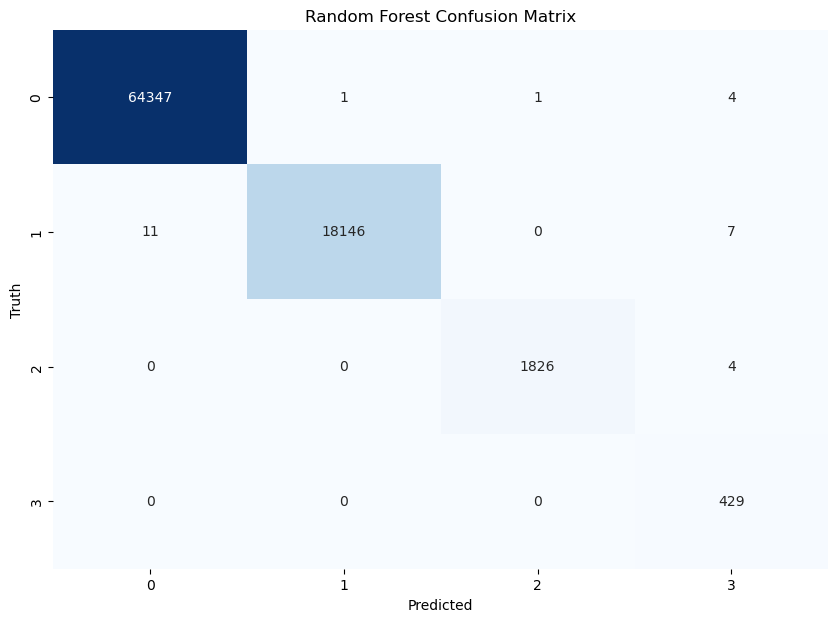

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64353
           1       1.00      1.00      1.00     18164
           2       1.00      1.00      1.00      1830
           3       0.97      1.00      0.98       429

    accuracy                           1.00     84776
   macro avg       0.99      1.00      1.00     84776
weighted avg       1.00      1.00      1.00     84776



In [8]:
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model performance on the cross validation set vs accuracy on the test set
cv_scores_mean_rf = np.mean(cv_scores_rf)
print(f'Cross validation average score: {cv_scores_mean_rf:.4f} +/- standard deviation: {np.std(cv_scores_rf):.4f}')

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy on the test set: {accuracy_rf:.4f}')
# Evaluating the model via confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Random Forest Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred_rf))

## 2.2. XGBoost

In [9]:
measurement_xgb = {}
cpu_usage = []
stop_flag = threading.Event()
xgb_model = xgb.XGBClassifier(
    subsample=1.0, 
    n_estimators=100, 
    min_child_weight=1, 
    max_depth=6, 
    learning_rate=0.2, 
    colsample_bytree=1.0, 
	objective='multi:softmax',
    random_state=42,
    n_jobs=-1)

def monitor_cpu():
        while not stop_flag.is_set():
            cpu_usage.append(psutil.cpu_percent(interval=0.1))

try :
    cpu_thread = threading.Thread(target=monitor_cpu)
    cpu_thread.start()
    start_time = time.time()

    train_memory_xgb = max(memory_usage(lambda: xgb_model.fit(X_train_resampled, y_train_resampled)))
    training_time = time.time() - start_time
    
    stop_flag.set()
    cpu_thread.join()
    
    # Add measurements
    measurement_xgb['Memory Usage (MB)'] = train_memory_xgb
    measurement_xgb['Training Time (s)'] = training_time
    measurement_xgb['Peak CPU Usage (%)'] = max(cpu_usage)
    measurement_xgb['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0
    
    cv_scores_xgb = cross_val_score(xgb_model, X_train_resampled, y_train_resampled, cv=5, n_jobs=-1)

except Exception as e:
    print(f"An error occurred during training or monitoring: {e}")

joblib.dump(xgb_model, '/home/wahba/Documents/model/multi_class_classification2/xgb_multi_class.joblib')

/home/wahba/miniconda3/envs/ml1/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/wahba/miniconda3/envs/ml1/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' varia

['/home/wahba/Documents/model/multi_class_classification2/xgb_multi_class.joblib']

Cross validation average score: 0.9997 +/- standard deviation: 0.0001
Accuracy on the test set: 0.9997


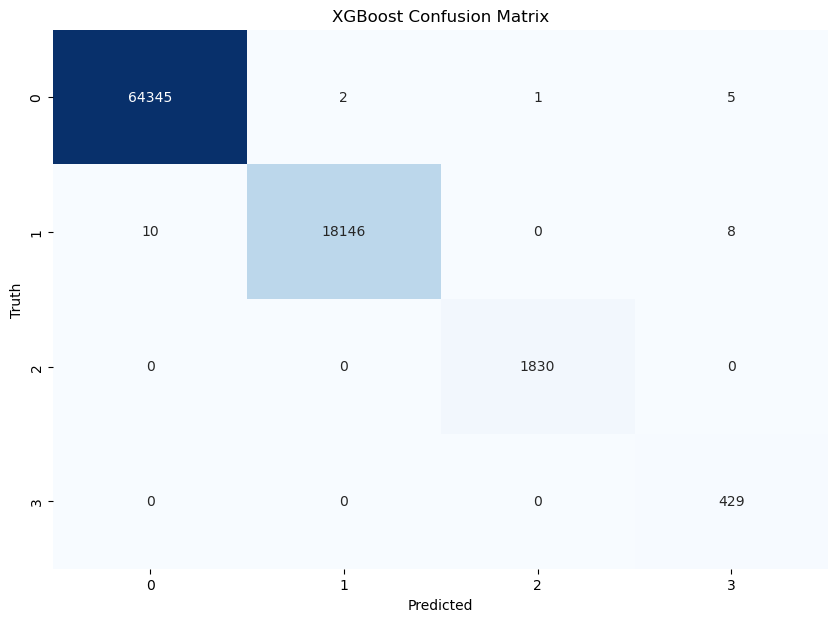

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64353
           1       1.00      1.00      1.00     18164
           2       1.00      1.00      1.00      1830
           3       0.97      1.00      0.99       429

    accuracy                           1.00     84776
   macro avg       0.99      1.00      1.00     84776
weighted avg       1.00      1.00      1.00     84776



In [10]:
y_pred_xgb = xgb_model.predict(X_test)

# Evaluating the model performance on the cross validation set vs accuracy on the test set
cv_scores_mean_xgb = np.mean(cv_scores_xgb)
print(f'Cross validation average score: {cv_scores_mean_xgb:.4f} +/- standard deviation: {np.std(cv_scores_xgb):.4f}')

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy on the test set: {accuracy_xgb:.4f}')
# Evaluating the model via confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_xgb, annot=True, fmt='d', xticklabels=xgb_model.classes_, yticklabels=xgb_model.classes_, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('XGBoost Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred_xgb))

## 2.3. K-Nearest Neighbour (KNN)

In [11]:
measurement_knn = {}
cpu_usage = []
stop_flag = threading.Event()
knn_model = KNeighborsClassifier(weights='distance', n_neighbors=3, n_jobs=-1)

def monitor_cpu():
        while not stop_flag.is_set():
            cpu_usage.append(psutil.cpu_percent(interval=0.1))

try :
    cpu_thread = threading.Thread(target=monitor_cpu)
    cpu_thread.start()
    start_time = time.time()

    train_memory_knn = max(memory_usage(lambda: knn_model.fit(X_train_scaled_resampled, y_train_scaled_resampled)))
    training_time = time.time() - start_time
    
    stop_flag.set()
    cpu_thread.join()
    
    # Add measurements
    measurement_knn['Memory Usage (MB)'] = train_memory_knn
    measurement_knn['Training Time (s)'] = training_time
    measurement_knn['Peak CPU Usage (%)'] = max(cpu_usage)
    measurement_knn['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0
    
    cv_scores_knn = cross_val_score(knn_model, X_train_scaled_resampled, y_train_scaled_resampled, cv=5, n_jobs=-1)

except Exception as e:
    print(f"An error occurred during training or monitoring: {e}")

joblib.dump(knn_model, '/home/wahba/Documents/model/multi_class_classification2/knn_multi_class.joblib')

['/home/wahba/Documents/model/multi_class_classification2/knn_multi_class.joblib']

Cross validation average score: 0.9977 +/- standard deviation: 0.0004
Accuracy on the test set: 0.9985


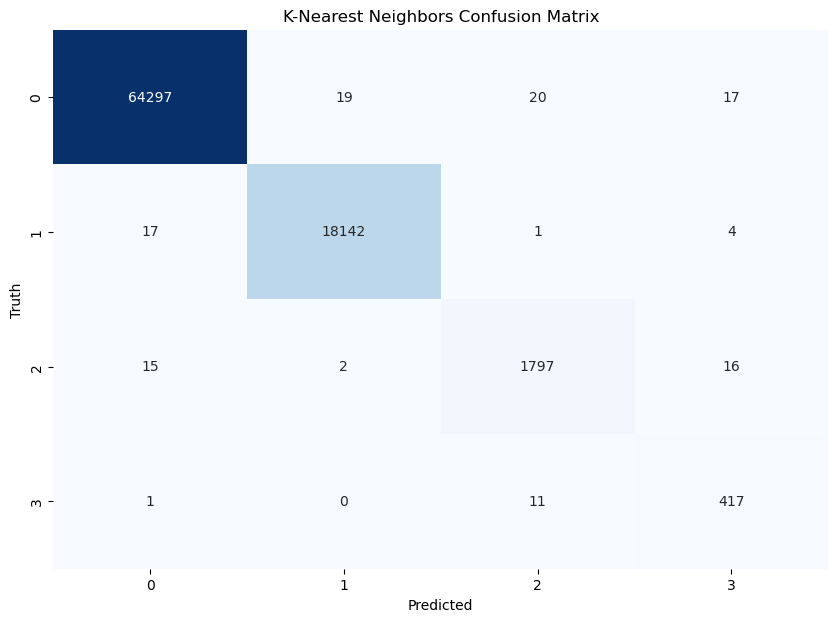

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64353
           1       1.00      1.00      1.00     18164
           2       0.98      0.98      0.98      1830
           3       0.92      0.97      0.94       429

    accuracy                           1.00     84776
   macro avg       0.97      0.99      0.98     84776
weighted avg       1.00      1.00      1.00     84776



In [12]:
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluating the model performance on the cross validation set vs accuracy on the test set
cv_scores_mean_knn = np.mean(cv_scores_knn)
print(f'Cross validation average score: {cv_scores_mean_knn:.4f} +/- standard deviation: {np.std(cv_scores_knn):.4f}')
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'Accuracy on the test set: {accuracy_knn:.4f}')
# Evaluating the model via confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_knn, annot=True, fmt='d', xticklabels=knn_model.classes_, yticklabels=knn_model.classes_, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('K-Nearest Neighbors Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred_knn))

# 3.0 Model Evaluation

In [13]:
# Calculating precision, recall, and F1 score for each model
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

supervised_results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'KNN'],
    'Accuracy': [accuracy_rf, accuracy_xgb, accuracy_knn],
    'Cross Validation Mean': [cv_scores_mean_rf, cv_scores_mean_xgb, cv_scores_mean_knn],
    'Precision': [precision_rf, precision_xgb, precision_knn],
    'Recall': [recall_rf, recall_xgb, recall_knn],
    'F1 Score': [f1_rf, f1_xgb, f1_knn],
    'Memory Usage (MB)': [measurement_rf['Memory Usage (MB)'], measurement_xgb['Memory Usage (MB)'], measurement_knn['Memory Usage (MB)']],
    'Training Time (s)': [measurement_rf['Training Time (s)'], measurement_xgb['Training Time (s)'], measurement_knn['Training Time (s)']],
    'Peak CPU Usage (%)': [measurement_rf['Peak CPU Usage (%)'], measurement_xgb['Peak CPU Usage (%)'], measurement_knn['Peak CPU Usage (%)']],
    'Average CPU Usage (%)': [measurement_rf['Average CPU Usage (%)'], measurement_xgb['Average CPU Usage (%)'], measurement_knn['Average CPU Usage (%)']],
})

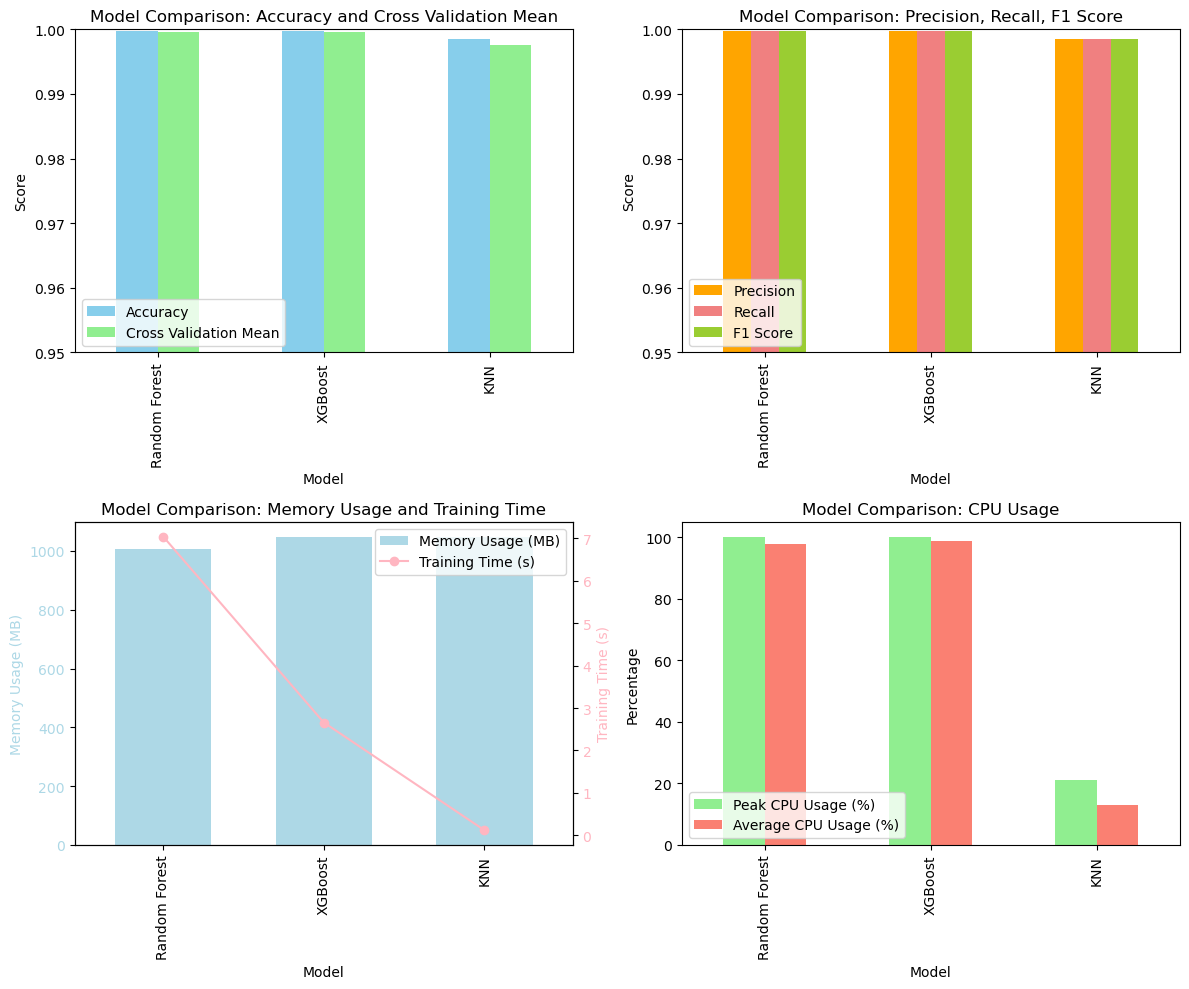

In [14]:
# Plotting the comparison for accuracy, cross-validation, and metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plotting Accuracy and Cross Validation Mean
supervised_results.set_index('Model')[['Accuracy', 'Cross Validation Mean']].plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'lightgreen'], legend=True)
axes[0, 0].set_title('Model Comparison: Accuracy and Cross Validation Mean')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylim(0.95, 1.0)
axes[0, 0].legend(loc='lower left')

# Plotting Precision, Recall, F1 Score
supervised_results.set_index('Model')[['Precision', 'Recall', 'F1 Score']].plot(kind='bar', ax=axes[0, 1], color=['orange', 'lightcoral', 'yellowgreen'], legend=True)
axes[0, 1].set_title('Model Comparison: Precision, Recall, F1 Score')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylim(0.95, 1.0)
axes[0, 1].legend(loc='lower left')

# Plotting Memory Usage and Training Time
ax1 = axes[1, 0]

supervised_results.set_index('Model')['Memory Usage (MB)'].plot(
    kind='bar', ax=ax1, color='lightblue', label='Memory Usage (MB)', width=0.6
)
ax1.set_ylabel('Memory Usage (MB)', color='lightblue')
ax1.tick_params(axis='y', labelcolor='lightblue')

ax2 = ax1.twinx() 
supervised_results.set_index('Model')['Training Time (s)'].plot(
    ax=ax2, color='lightpink', marker='o', label='Training Time (s)'
)

ax2.set_ylabel('Training Time (s)', color='lightpink')
ax2.tick_params(axis='y', labelcolor='lightpink')

ax1.set_title('Model Comparison: Memory Usage and Training Time')
ax1.set_xlabel('Model')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Plotting Peak and Average CPU Usage
supervised_results.set_index('Model')[['Peak CPU Usage (%)', 'Average CPU Usage (%)']].plot(kind='bar', ax=axes[1, 1], color=['lightgreen', 'salmon'], legend=True)
axes[1, 1].set_title('Model Comparison: CPU Usage')
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].set_xlabel('Model')
axes[1, 1].legend(loc='lower left')

plt.tight_layout()
plt.show()


In [15]:
print(f'''
    {measurement_rf}
    {measurement_xgb}
    {measurement_knn}
    ''')


    {'Memory Usage (MB)': 1007.30078125, 'Training Time (s)': 7.045135974884033, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 97.68285714285716}
    {'Memory Usage (MB)': 1045.8125, 'Training Time (s)': 2.6588594913482666, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 98.7148148148148}
    {'Memory Usage (MB)': 1046.48046875, 'Training Time (s)': 0.11688828468322754, 'Peak CPU Usage (%)': 21.0, 'Average CPU Usage (%)': 13.0}
    
